In [16]:
import wandb
import yaml
from utils import correct_type_of_entry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from copy import deepcopy
import seaborn as sn
pd.set_option('display.max_rows', None)

In [176]:
dataset = "concrete"
sweep_config = "forest"
values_to_fetch = ['kl_bound', 'compression_set_size', 'complement_loss', 'validation_loss', 'test_loss']

In [177]:
sweep_config_name = "./configs/sweep_configs/" + sweep_config + ".yaml"
with open(sweep_config_name) as file:
    sweep_configuration = yaml.safe_load(file)
    
hps = {}
for key, item in sweep_configuration['parameters'].items():
    if item.get('values', None) is not None:
        hps[key] = correct_type_of_entry(item['values'])
size_hyperparams = tuple([len(l) for l in hps.values()])

In [178]:
api = wandb.Api()
entity = "mathieu-bazinet"
project = "sweep" + dataset
runs = api.runs(entity + "/" + project)

In [179]:
results_matrix = np.ones(((len(values_to_fetch),) + size_hyperparams))

for run_idx in range(len(runs)):
    run = runs[run_idx]
    if run.config['model_type'] == sweep_config:
        for val_to_fetch_idx in range(len(values_to_fetch)):
            matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
            val_to_fetch = values_to_fetch[val_to_fetch_idx]
            try:
                results_matrix[matrix_idx] = run.summary[val_to_fetch]
            except KeyError:
                results_matrix[matrix_idx] = [row[val_to_fetch] for row in run.scan_history(keys=[val_to_fetch])][-1]

In [180]:
hp_list = list(hps.values())[1:]
params_product = list(product(*hp_list))
name_list = []
idx_list = []
for params in params_product:
    name = ""
    for p in params:
        name += str(p) + " "
    name_list.append(name[:-1])
    idx = ()
    for p_idx in range(len(params)):
        p_key = list(hps.keys())[1:][p_idx]
        idx += (hps[p_key].index(params[p_idx]),)
    idx_list.append(tuple(idx))

In [181]:
reshaped_matrix = results_matrix.mean(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
mean_df = pd.DataFrame(reshaped_matrix, index=name_list, columns=values_to_fetch)
mean_df

,kl_bound,compression_set_size,complement_loss,validation_loss,test_loss
5 2 1 50 0.0,30.772499,28.4,8.413947,8.658409,8.925168
5 2 1 50 0.05,33.557428,42.8,7.744574,8.252283,8.248198
5 2 1 50 0.1,33.446774,42.4,7.361749,7.794745,7.998402
5 2 1 50 0.2,31.188455,30.0,8.320428,8.756390,8.946741
5 2 1 100 0.0,33.777402,49.0,6.381846,7.056922,6.716611
5 2 1 100 0.05,33.978653,49.8,6.489063,6.960322,7.064359
5 2 1 100 0.1,34.455841,53.0,6.218355,6.819836,6.800957
5 2 1 100 0.2,32.431669,44.0,6.297903,6.737023,6.758290
5 2 2 50 0.0,36.079700,57.2,6.585080,7.237830,6.940935
5 2 2 50 0.05,33.423524,42.8,7.169669,7.827142,7.641265


/var/folders/t7/t2tk8_dd3vsc811yh2mdwbbh0000gp/T/ipykernel_8311/229026533.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


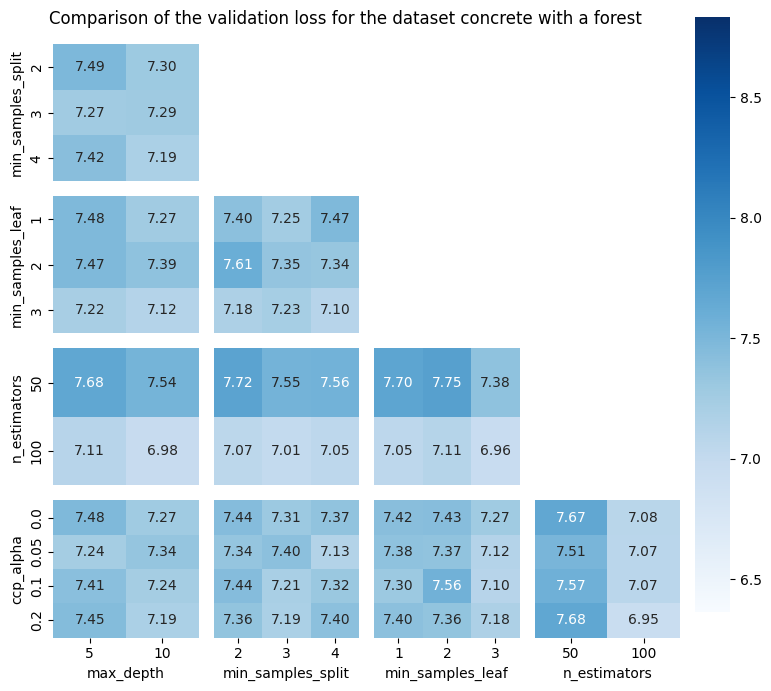

In [183]:
index = 3
mean_arr = results_matrix.mean(1)[index]
key_list = list(hps.keys())[1:]

fig, axs = plt.subplots(len(key_list)-1, len(key_list)-1, figsize=(7,7))
for i in range(0,len(key_list)-1):
    for j in range(i+1,len(key_list)-1):
        fig.delaxes(axs[i, j])

fig.subplots_adjust(right=0.8)

cmap = 'Blues'
vmax = mean_arr.max()
vmin = mean_arr.min()

for i in range(0,len(key_list)-1):
    for j in range(i+1,len(key_list)):
        index_list = list(range(len(key_list)))
        index_list.remove(i)
        index_list.remove(j)
        index_list = index_list[::-1]
        new_arr = mean_arr.mean(index_list[0])
        for k in range(1,len(index_list)):
            new_arr = new_arr.mean(index_list[k])
        df = pd.DataFrame(new_arr.T, index=hps[key_list[j]], columns=hps[key_list[i]])
        if i != 0:
            yticklabels = False
        else:
            yticklabels = True
            axs[j-1,i].set(xlabel=key_list[j])
        if j+1 != len(key_list):
            xticklabels = False
        else:
            xticklabels = True
            axs[j-1,i].set(ylabel=key_list[i])
            
        if j == 1 and i == 0:
            cbar_ax = fig.add_axes([1, 0.12, 0.05, 0.85])
            cbar = True
        else:
            cbar_ax = None
            cbar = False
        
        sn.heatmap(df, annot=True,fmt=".2f", ax=axs[j-1,i], cbar=cbar, vmin=vmin, vmax=vmax,
                cmap=cmap, xticklabels=xticklabels, yticklabels=yticklabels, cbar_ax=cbar_ax)
        if j+1 == len(key_list):
            axs[j-1, i].set(xlabel=key_list[i])
        if i == 0:
            axs[j-1, i].set(ylabel=key_list[j])

fig.suptitle(f"Comparison of the {values_to_fetch[index].replace("_", " ")} for the dataset {dataset} with a {sweep_config}")
# # Layout so plots do not overlap
fig.tight_layout()
fig.align_labels()
plt.savefig(f"./results/trees/{dataset}_{sweep_config}_{values_to_fetch[index]}_heatmaps.jpg", bbox_inches='tight')